# Link Spreadsheet Performa

https://docs.google.com/spreadsheets/d/1Dx7pqnXGlv5xKqnye_vGw1ewy_KjgRKoFBN7WEaLlyI/edit#gid=0

# Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Set Random Seed

In [3]:
def random_seed(seed_value):
    import os
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    import random 
    random.seed(seed_value) # Python
    import numpy as np
    np.random.seed(seed_value) # cpu vars
    import torch
    torch.manual_seed(seed_value) # cpu  vars

    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

random_seed(42)

# Dataset and Dataloader

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

## Load Dataset 

In [5]:
bs = 64
crop_size = 224

transform = transforms.Compose([
  transforms.Resize((crop_size, crop_size)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
data_domain1 = datasets.ImageFolder("oxford_102_flower", transform=transform)

# Split into Train Val
random_seed = 42
torch.manual_seed(random_seed)

val_size = int(len(data_domain1) * 0.15)
train_size = len(data_domain1) - (val_size)

train_set, val_set = random_split(
    data_domain1,
    [train_size, val_size]
)


trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)
valloader = DataLoader(val_set, batch_size=bs)

In [7]:
data_benchmark = datasets.ImageFolder("benchmark", transform=transform)
benchmarkloader = DataLoader(data_benchmark, batch_size=bs)

In [8]:
len(train_set), len(val_set)

(425, 75)

In [9]:
label2cat = data_domain1.classes
label2cat

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Architecture and Config

In [10]:
from torch import nn
import timm

class ActiveLearningNet(nn.Module):
    def __init__(self, output_size=2):
        super().__init__()
        self.basemodel = timm.create_model('resnext50_32x4d', pretrained=True)
        self.freeze()
        self.basemodel.fc = nn.Sequential(
            nn.Linear(2048, output_size),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = self.basemodel(x)
        return x

    def freeze(self):
        for param in self.basemodel.parameters():
            param.requires_grad = False # Freezing Weight
    
    def unfreeze(self):
        for param in self.basemodel.parameters():
            param.requires_grad = True # Unfreezing Weight

    def predict(self, x):
        with torch.no_grad():
            self.basemodel.eval()
            output = self.basemodel(x)
            preds = output.argmax(1)
        return preds

In [11]:
config = set_config({
    "output_size": len(data_domain1.classes),
    "batch_size": bs,
    "crop_size": crop_size
})

# Model 1 (Baseline model)

## Adaptation

In [11]:
model = ActiveLearningNet(config.output_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir="model1")

In [12]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == "train":
    model.train()
  elif mode == "test":
    model.eval()
  cost = correct = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output = model(feature)
    loss = criterion(output, target)

    if mode == "train":
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    cost += loss.item() * feature.shape[0]
    correct += (output.argmax(1) == target).sum().item()
  cost = cost / len(dataset)
  acc = correct / len(dataset)
  return cost, acc

Train:   0%|          | 0/7 [00:00<?, ?it/s]

/home/mamad/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 1.2956 | Test_cost  = 0.8817 | Train_score = 0.6000 | Test_score = 0.8533 |


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.7300 | Test_cost  = 0.6021 | Train_score = 0.8941 | Test_score = 0.8667 |


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.4447 | Test_cost  = 0.5088 | Train_score = 0.9435 | Test_score = 0.8800 |


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.3227 | Test_cost  = 0.4467 | Train_score = 0.9576 | Test_score = 0.8667 |
==> EarlyStop patience =  1 | Best test_score: 0.8800


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.2262 | Test_cost  = 0.4062 | Train_score = 0.9741 | Test_score = 0.8533 |
==> EarlyStop patience =  2 | Best test_score: 0.8800
==> Execute Early Stopping at epoch: 5 | Best test_score: 0.8800
==> Best model is saved at model1


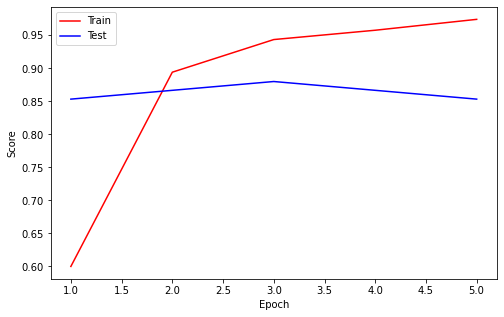

In [13]:
while True:
  train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn("test", val_set, valloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor="test_score"):
    callback.plot_cost()
    callback.plot_score()
    break

## Fine-Tuning

In [14]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5) # 10 ^ -5

callback.reset_early_stop()
callback.early_stop_patience = 5

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.3234 | Test_cost  = 0.4446 | Train_score = 0.9671 | Test_score = 0.8667 |
==> EarlyStop patience =  1 | Best test_score: 0.8800


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.2083 | Test_cost  = 0.3925 | Train_score = 0.9882 | Test_score = 0.8667 |
==> EarlyStop patience =  2 | Best test_score: 0.8800


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.1464 | Test_cost  = 0.3574 | Train_score = 0.9976 | Test_score = 0.8933 |


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.1007 | Test_cost  = 0.3376 | Train_score = 0.9976 | Test_score = 0.8667 |
==> EarlyStop patience =  1 | Best test_score: 0.8933


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.0702 | Test_cost  = 0.3151 | Train_score = 1.0000 | Test_score = 0.8667 |
==> EarlyStop patience =  2 | Best test_score: 0.8933


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.0659 | Test_cost  = 0.3043 | Train_score = 1.0000 | Test_score = 0.8800 |
==> EarlyStop patience =  3 | Best test_score: 0.8933


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.0447 | Test_cost  = 0.2886 | Train_score = 1.0000 | Test_score = 0.8800 |
==> EarlyStop patience =  4 | Best test_score: 0.8933


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.0328 | Test_cost  = 0.2755 | Train_score = 1.0000 | Test_score = 0.8933 |
==> EarlyStop patience =  5 | Best test_score: 0.8933
==> Execute Early Stopping at epoch: 13 | Best test_score: 0.8933
==> Best model is saved at model1


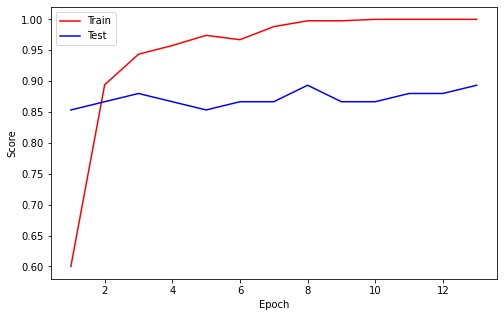

In [15]:
while True:
  train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn("test", val_set, valloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor="test_score"):
    callback.plot_cost()
    callback.plot_score()
    break

## Model 1 Evaluation

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

In [61]:
def predict(model, test_loader, device):
    model.eval()
    
    targets = torch.tensor([], dtype=torch.long, device=device)
    preds = torch.tensor([], device=device)
    
    with torch.no_grad():
        for data in test_loader:
            inputs = [i.to(device) for i in data[:-1]]
            labels = data[-1].to(device)
            
            outputs = model(*inputs)
            targets = torch.cat((targets, labels), 0)
            preds = torch.cat((preds, outputs), 0)
    
    targets = targets.cpu().numpy()  
    _, preds_out = torch.max(preds, 1)
    preds_out = preds_out.cpu().numpy()
    probs = nn.functional.softmax(preds, dim=1).cpu().numpy()
    
    return targets, preds_out, probs

In [18]:
target, preds, y_pred_prob = predict(model, valloader, device)

In [19]:
print(classification_report(target, preds, target_names=label2cat))

              precision    recall  f1-score   support

       daisy       1.00      0.91      0.95        11
   dandelion       1.00      0.79      0.88        14
       roses       0.90      1.00      0.95        19
  sunflowers       0.85      0.94      0.89        18
      tulips       0.77      0.77      0.77        13

    accuracy                           0.89        75
   macro avg       0.90      0.88      0.89        75
weighted avg       0.90      0.89      0.89        75



## Model 1 Benchmark

In [20]:
target, preds, y_pred_prob = predict(model, benchmarkloader, device)

In [21]:
print(classification_report(target, preds, target_names=label2cat))

              precision    recall  f1-score   support

       daisy       0.88      0.70      0.78        50
   dandelion       0.73      0.88      0.80        50
       roses       0.96      0.52      0.68        50
  sunflowers       0.80      0.72      0.76        50
      tulips       0.62      0.96      0.75        50

    accuracy                           0.76       250
   macro avg       0.80      0.76      0.75       250
weighted avg       0.80      0.76      0.75       250



In [22]:
cf_matrix = confusion_matrix(target, preds)
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label2cat).plot(values_format='.4g')

# Model 2 (Full domain2)

In [23]:
model = ActiveLearningNet(config.output_size).to(device)
model.load_state_dict(torch.load('model1/weights_best.pth', map_location=device))

<All keys matched successfully>

In [24]:
data_domain2 = datasets.ImageFolder("flower_recognition", transform=transform)

data_merged = torch.utils.data.ConcatDataset([data_domain1, data_domain2])

val_size = int(len(data_merged) * 0.15)
train_size = len(data_merged) - (val_size)

train_set, val_set = random_split(
    data_merged,
    [train_size, val_size]
)


trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)
valloader = DataLoader(val_set, batch_size=bs)

In [47]:
len(data_merged)

3718

## Fine-tuning with Domain2

In [25]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5) # 10 ^ -5

callback = Callback(model, config, early_stop_patience=5, outdir="model2")
callback.early_stop_patience = 5

Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.4794 | Test_cost  = 0.3192 | Train_score = 0.8402 | Test_score = 0.9138 |


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.2646 | Test_cost  = 0.2369 | Train_score = 0.9291 | Test_score = 0.9318 |


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.1722 | Test_cost  = 0.1979 | Train_score = 0.9614 | Test_score = 0.9408 |


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.1091 | Test_cost  = 0.1779 | Train_score = 0.9791 | Test_score = 0.9425 |


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.0747 | Test_cost  = 0.1600 | Train_score = 0.9883 | Test_score = 0.9425 |
==> EarlyStop patience =  1 | Best test_score: 0.9425


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.0502 | Test_cost  = 0.1510 | Train_score = 0.9940 | Test_score = 0.9479 |


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.0424 | Test_cost  = 0.1448 | Train_score = 0.9949 | Test_score = 0.9497 |


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.0305 | Test_cost  = 0.1387 | Train_score = 0.9968 | Test_score = 0.9497 |
==> EarlyStop patience =  1 | Best test_score: 0.9497


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.0243 | Test_cost  = 0.1302 | Train_score = 0.9984 | Test_score = 0.9533 |


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.0184 | Test_cost  = 0.1327 | Train_score = 0.9991 | Test_score = 0.9551 |


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.0157 | Test_cost  = 0.1295 | Train_score = 0.9987 | Test_score = 0.9569 |


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.0139 | Test_cost  = 0.1316 | Train_score = 0.9991 | Test_score = 0.9515 |
==> EarlyStop patience =  1 | Best test_score: 0.9569


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.0118 | Test_cost  = 0.1329 | Train_score = 0.9991 | Test_score = 0.9551 |
==> EarlyStop patience =  2 | Best test_score: 0.9569


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.0100 | Test_cost  = 0.1271 | Train_score = 0.9987 | Test_score = 0.9569 |
==> EarlyStop patience =  3 | Best test_score: 0.9569


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.0098 | Test_cost  = 0.1308 | Train_score = 0.9978 | Test_score = 0.9587 |


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.0078 | Test_cost  = 0.1367 | Train_score = 0.9994 | Test_score = 0.9551 |
==> EarlyStop patience =  1 | Best test_score: 0.9587


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.0069 | Test_cost  = 0.1302 | Train_score = 0.9994 | Test_score = 0.9587 |
==> EarlyStop patience =  2 | Best test_score: 0.9587


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.0064 | Test_cost  = 0.1363 | Train_score = 1.0000 | Test_score = 0.9587 |
==> EarlyStop patience =  3 | Best test_score: 0.9587


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.0061 | Test_cost  = 0.1342 | Train_score = 0.9994 | Test_score = 0.9551 |
==> EarlyStop patience =  4 | Best test_score: 0.9587


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.0063 | Test_cost  = 0.1424 | Train_score = 0.9994 | Test_score = 0.9497 |


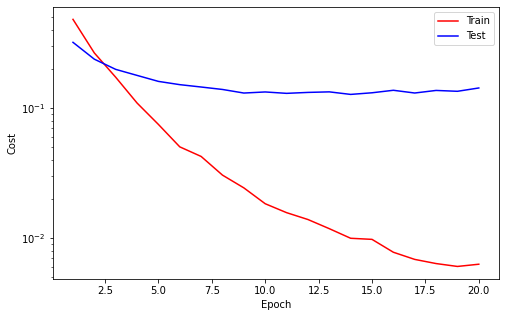

==> EarlyStop patience =  5 | Best test_score: 0.9587
==> Execute Early Stopping at epoch: 20 | Best test_score: 0.9587
==> Best model is saved at model2


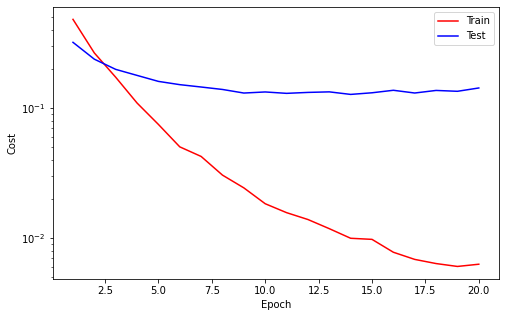

In [26]:
while True:
  train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn("test", val_set, valloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor="test_score"):
    callback.plot_cost()
    callback.plot_score()
    break

## Model 2 Benchmark

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
target, preds, y_pred_prob = predict(model, benchmarkloader, device)

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

cf_matrix = confusion_matrix(target, preds)
print(classification_report(target, preds, target_names=label2cat))
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label2cat).plot(values_format='.4g')

              precision    recall  f1-score   support

       daisy       0.94      0.88      0.91        50
   dandelion       0.98      0.96      0.97        50
       roses       0.94      0.92      0.93        50
  sunflowers       0.98      0.94      0.96        50
      tulips       0.88      1.00      0.93        50

    accuracy                           0.94       250
   macro avg       0.94      0.94      0.94       250
weighted avg       0.94      0.94      0.94       250



# Split data to 20 and 80

In [48]:
data_domain2 = datasets.ImageFolder("flower_recognition", transform=transform)

# data_merged = torch.utils.data.ConcatDataset([data_domain1, data_domain2])

data_domain2_20_size = int(len(data_domain2) * 0.2)
data_domain2_80_size = len(data_domain2) - (data_domain2_20_size)

data_domain2_20_random, data_domain2_80_random = random_split(data_domain2, [data_domain2_20_size, data_domain2_80_size],torch.Generator().manual_seed(42))
# trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)
# valloader = DataLoader(val_set, batch_size=bs)

In [49]:
labels = []
for data, label in data_domain2_20_random:
#     print(label)
    labels.append(label)
dct = dict(Counter(labels))

for k, v in dct.items():
    print(f'{label2cat[k]} has {v} instances')

dandelion has 165 instances
sunflowers has 131 instances
daisy has 95 instances
tulips has 134 instances
roses has 118 instances


In [50]:
from collections import Counter

In [51]:
dict(Counter(data_domain2.targets))

{0: 532, 1: 797, 2: 591, 3: 610, 4: 688}

In [52]:
type(data_domain2_20_random)

torch.utils.data.dataset.Subset

# Model 3 (Random sampling)

In [53]:
# Merging 20% Random and Domain1
data_merged_20_random = torch.utils.data.ConcatDataset([data_domain1, data_domain2_20_random])

val_size = int(len(data_merged_20_random) * 0.15)
train_size = len(data_merged_20_random) - (val_size)

train_set, val_set = random_split(
    data_merged_20_random,
    [train_size, val_size]
)


trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)
valloader = DataLoader(val_set, batch_size=bs)

In [54]:
labels = []
for data, label in data_merged_20_random:
#     print(label)
    labels.append(label)
dct = dict(Counter(labels))

for k, v in dct.items():
    print(f'{label2cat[k]} has {v} instances')

daisy has 195 instances
dandelion has 265 instances
roses has 218 instances
sunflowers has 231 instances
tulips has 234 instances


In [55]:
model = ActiveLearningNet(config.output_size).to(device)
model.load_state_dict(torch.load('model1/weights_best.pth', map_location=device))

<All keys matched successfully>

In [56]:
model.unfreeze()
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback = Callback(model, config, early_stop_patience=5, outdir="model3")

Train:   0%|          | 0/16 [00:00<?, ?it/s]

/home/mamad/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.4428 | Test_cost  = 0.3377 | Train_score = 0.8591 | Test_score = 0.8947 |


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.2832 | Test_cost  = 0.2901 | Train_score = 0.9321 | Test_score = 0.9181 |


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.2046 | Test_cost  = 0.2625 | Train_score = 0.9630 | Test_score = 0.9240 |


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.1443 | Test_cost  = 0.2308 | Train_score = 0.9805 | Test_score = 0.9357 |


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.1136 | Test_cost  = 0.2124 | Train_score = 0.9846 | Test_score = 0.9415 |


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.0864 | Test_cost  = 0.2023 | Train_score = 0.9949 | Test_score = 0.9357 |
==> EarlyStop patience =  1 | Best test_score: 0.9415


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.0655 | Test_cost  = 0.1932 | Train_score = 0.9949 | Test_score = 0.9298 |
==> EarlyStop patience =  2 | Best test_score: 0.9415


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.0528 | Test_cost  = 0.1773 | Train_score = 0.9990 | Test_score = 0.9357 |
==> EarlyStop patience =  3 | Best test_score: 0.9415


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.0467 | Test_cost  = 0.1703 | Train_score = 0.9979 | Test_score = 0.9357 |
==> EarlyStop patience =  4 | Best test_score: 0.9415


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.0361 | Test_cost  = 0.1572 | Train_score = 0.9990 | Test_score = 0.9415 |
==> EarlyStop patience =  5 | Best test_score: 0.9415
==> Execute Early Stopping at epoch: 10 | Best test_score: 0.9415
==> Best model is saved at model3


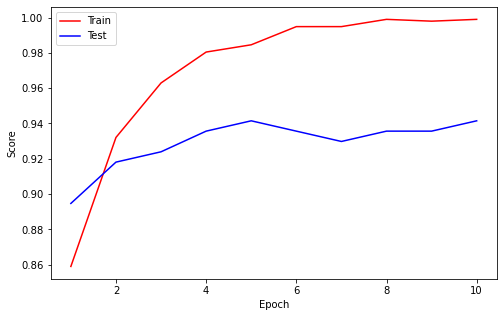

In [59]:
while True:
  train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn("test", val_set, valloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor="test_score"):
    callback.plot_cost()
    callback.plot_score()
    break

## Model 3 Benchmark

In [62]:
from sklearn.metrics import classification_report, confusion_matrix
target, preds, y_pred_prob = predict(model, benchmarkloader, device)

In [63]:
from sklearn.metrics import ConfusionMatrixDisplay

cf_matrix = confusion_matrix(target, preds)
print(classification_report(target, preds, target_names=label2cat))
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label2cat).plot(values_format='.4g')

              precision    recall  f1-score   support

       daisy       0.95      0.76      0.84        50
   dandelion       0.87      0.94      0.90        50
       roses       0.97      0.74      0.84        50
  sunflowers       0.89      0.84      0.87        50
      tulips       0.69      0.98      0.81        50

    accuracy                           0.85       250
   macro avg       0.88      0.85      0.85       250
weighted avg       0.88      0.85      0.85       250



# Model 4 (Least Confidence Sampling)

In [14]:
model = ActiveLearningNet(config.output_size).to(device)
model.load_state_dict(torch.load('model1/weights_best.pth', map_location=device))

<All keys matched successfully>

In [15]:
model.unfreeze()
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback = Callback(model, config, early_stop_patience=5, outdir="model4")

In [14]:
data_domain2 = datasets.ImageFolder("flower_recognition", transform=transform)

domain2_loader = DataLoader(data_domain2, batch_size=1, shuffle=True)

In [15]:
def least_confidence(prob_dist):
        """ 
        Returns the uncertainty score of an array using
        least confidence sampling in a 0-1 range where 1 is the most uncertain
        
        Assumes probability distribution is a pytorch tensor, like: 
            tensor([0.0321, 0.6439, 0.0871, 0.2369])
                    
        Keyword arguments:
            prob_dist -- a pytorch tensor of real numbers between 0 and 1 that total to 1.0
            sorted -- if the probability distribution is pre-sorted from largest to smallest
        """
        prob_dist = torch.tensor(prob_dist).to(device)
        simple_least_conf = torch.max(prob_dist) # most confident prediction
                    
        num_labels = prob_dist.numel() # number of labels
        
        normalized_least_conf = (1 - simple_least_conf) * (num_labels / (num_labels -1))
        
        return normalized_least_conf.item()

In [16]:
def get_confidence(model, data_loader, device):
    model.eval()
    
    targets = torch.tensor([], dtype=torch.long, device=device)
    preds = torch.tensor([], device=device)
    samples = torch.tensor([], device=device)
    conf = []
    
    with torch.no_grad():
        for data in data_loader:
            inputs = [i.to(device) for i in data[:-1]]
            labels = data[-1].to(device)
            outputs = model(*inputs)
            targets = torch.cat((targets, labels), 0)
            preds = torch.cat((preds, outputs), 0)
            samples = torch.cat((samples, data[0].to(device)), 0)
             
    _, preds_out = torch.max(preds, 1)
    preds_out = preds_out
    probs = nn.functional.softmax(preds, dim=1)
    for prob in probs:
        conf.append(least_confidence(prob))
    conf = torch.tensor(conf, device=device)
    return samples, conf, targets

In [18]:
def get_samples_least_conf(model, imagefolder, device, sample_pct=0.2):
    sample_size = int(len(imagefolder) * sample_pct)
#     conf, targets= get_confidence(model, imagefolder, device)
    samples, conf, targets = get_confidence(model, imagefolder, device)
    samples_out = samples[conf.argsort()][:sample_size]
    targets_out = targets[conf.argsort()][:sample_size]
    samples_not = samples[conf.argsort()][sample_size:]
    targets_not = targets[conf.argsort()][sample_size:]
#     targets_return = torch.tensor([torch.tensor(t).to(device) for t in targets], device=device)
    return samples_out, targets_out, samples_not, targets_not

In [19]:
samples_gpu, targets_gpu, samples_not_gpu, targets_not_gpu = get_samples_least_conf(model, domain2_loader, device)

/home/mamad/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
<ipython-input-15-e92f841e709d>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prob_dist = torch.tensor(prob_dist).to(device)


In [20]:
from torch.utils.data import TensorDataset, DataLoader

In [25]:
samples_not_cpu, targets_not_cpu = samples_not_gpu.detach().cpu(), targets_not_gpu.detach().cpu()

In [ ]:
samples_cpu, targets_cpu = samples_gpu.detach().cpu(), targets_gpu.detach().cpu()

In [22]:
my_dataset = TensorDataset(samples_gpu,targets_gpu)
dataloader = DataLoader(my_dataset)

In [26]:
my_dataset2 = TensorDataset(samples_not_gpu,targets_not_gpu)
dataloader2 = DataLoader(my_dataset2)

## Saving images from sampling

In [23]:
import os
for label in label2cat:
    try:
        os.makedirs("data4_sampling/{}".format(label))
    except FileExistsError:
        # directory already exists
        pass
    
from torchvision.utils import save_image

In [24]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

for idx, data in enumerate(my_dataset):
    target = data[1]
    data = invTrans(data[0])
    save_image(data, 'data4_sampling/{}/{}'.format(label2cat[target.item()], str(idx)+'.jpg'))

In [30]:
import os
for label in label2cat:
    try:
        os.makedirs("data4_not_picked/{}".format(label))
    except FileExistsError:
        # directory already exists
        pass
    
from torchvision.utils import save_image

In [31]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

for idx, data in enumerate(my_dataset2):
    target = data[1]
    data = invTrans(data[0])
    save_image(data, 'data4_not_picked/{}/{}'.format(label2cat[target.item()], str(idx)+'.jpg'))

## Combining images from domain1 to sampling

In [32]:
!mkdir data4_merged
!rsync -avq data4_sampling/* data4_merged
!rsync -avq oxford_102_flower/* data4_merged

## Fine-Tuning

In [12]:
data_train = datasets.ImageFolder("data4_merged", transform=transform)

val_size = int(len(data_train) * 0.15)
train_size = len(data_train) - (val_size)

train_set, val_set = random_split(
    data_train,
    [train_size, val_size]
)


trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)
valloader = DataLoader(val_set, batch_size=bs)

In [23]:
labels = []
for data, label in data_train:
#     print(label)
    labels.append(label)
dct = dict(Counter(labels))

for k, v in dct.items():
    print(f'{label2cat[k]} has {v} instances')

daisy has 240 instances
dandelion has 320 instances
roses has 136 instances
sunflowers has 225 instances
tulips has 222 instances


Train:   0%|          | 0/16 [00:00<?, ?it/s]

/home/mamad/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.1803 | Test_cost  = 0.1024 | Train_score = 0.9763 | Test_score = 0.9883 |


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.0980 | Test_cost  = 0.0890 | Train_score = 0.9866 | Test_score = 0.9883 |
==> EarlyStop patience =  1 | Best test_score: 0.9883


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.0643 | Test_cost  = 0.0743 | Train_score = 0.9928 | Test_score = 0.9883 |
==> EarlyStop patience =  2 | Best test_score: 0.9883


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.0440 | Test_cost  = 0.0713 | Train_score = 0.9959 | Test_score = 0.9883 |
==> EarlyStop patience =  3 | Best test_score: 0.9883


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.0293 | Test_cost  = 0.0648 | Train_score = 0.9990 | Test_score = 0.9883 |
==> EarlyStop patience =  4 | Best test_score: 0.9883


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.0215 | Test_cost  = 0.0615 | Train_score = 1.0000 | Test_score = 0.9883 |
==> EarlyStop patience =  5 | Best test_score: 0.9883
==> Execute Early Stopping at epoch: 6 | Best test_score: 0.9883
==> Best model is saved at model4


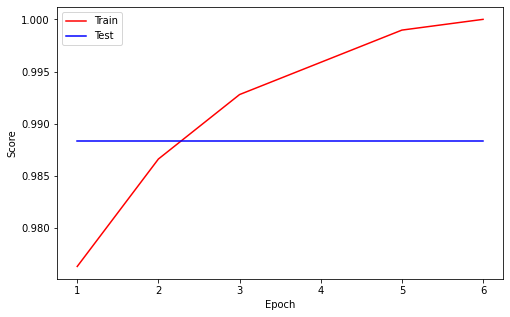

In [16]:
while True:
  train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn("test", val_set, valloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor="test_score"):
    callback.plot_cost()
    callback.plot_score()
    break

## Model 4 Benchmark

In [17]:
def predict(model, test_loader, device):
    model.eval()
    
    targets = torch.tensor([], dtype=torch.long, device=device)
    preds = torch.tensor([], device=device)
    
    with torch.no_grad():
        for data in test_loader:
            inputs = [i.to(device) for i in data[:-1]]
            labels = data[-1].to(device)
            
            outputs = model(*inputs)
            targets = torch.cat((targets, labels), 0)
            preds = torch.cat((preds, outputs), 0)
    
    targets = targets.cpu().numpy()  
    _, preds_out = torch.max(preds, 1)
    preds_out = preds_out.cpu().numpy()
    probs = nn.functional.softmax(preds, dim=1).cpu().numpy()
    
    return targets, preds_out, probs

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
target, preds, y_pred_prob = predict(model, benchmarkloader, device)

              precision    recall  f1-score   support

       daisy       0.90      0.72      0.80        50
   dandelion       0.76      0.88      0.81        50
       roses       0.94      0.66      0.78        50
  sunflowers       0.78      0.72      0.75        50
      tulips       0.68      0.96      0.79        50

    accuracy                           0.79       250
   macro avg       0.81      0.79      0.79       250
weighted avg       0.81      0.79      0.79       250



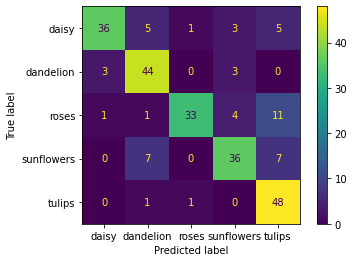

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

cf_matrix = confusion_matrix(target, preds)
print(classification_report(target, preds, target_names=label2cat))
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label2cat).plot(values_format='.4g')

# Model 5 (Margin of Confidence Sampling)

In [14]:
model = ActiveLearningNet(config.output_size).to(device)
model.load_state_dict(torch.load('model1/weights_best.pth', map_location=device))

<All keys matched successfully>

In [15]:
model.unfreeze()
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

config = set_config({
    "output_size": len(data_domain1.classes),
    "batch_size": 32,
    "crop_size": crop_size
})

callback = Callback(model, config, early_stop_patience=5, outdir="model5")

In [13]:
data_domain2 = datasets.ImageFolder("flower_recognition", transform=transform)

domain2_loader = DataLoader(data_domain2, batch_size=1, shuffle=True)

In [14]:
def margin_confidence(prob_dist):
    """ 
    Returns the uncertainty score of a probability distribution using
    margin of confidence sampling in a 0-1 range where 1 is the most uncertain

    Assumes probability distribution is a pytorch tensor, like: 
        tensor([0.0321, 0.6439, 0.0871, 0.2369])

    Keyword arguments:
        prob_dist -- a pytorch tensor of real numbers between 0 and 1 that total to 1.0
        sorted -- if the probability distribution is pre-sorted from largest to smallest
    """
    difference = (prob_dist.data[0] - prob_dist.data[1]) # difference between top two props
    margin_conf = 1 - difference 

    return margin_conf.item()

In [15]:
def get_confidence(model, data_loader, device):
    model.eval()
    
    targets = torch.tensor([], dtype=torch.long, device=device)
    preds = torch.tensor([], device=device)
    samples = torch.tensor([], device=device)
    conf = []
    
    with torch.no_grad():
        for data in data_loader:
            inputs = [i.to(device) for i in data[:-1]]
            labels = data[-1].to(device)
            outputs = model(*inputs)
            targets = torch.cat((targets, labels), 0)
            preds = torch.cat((preds, outputs), 0)
            samples = torch.cat((samples, data[0].to(device)), 0)
             
    _, preds_out = torch.max(preds, 1)
    preds_out = preds_out
    probs = nn.functional.softmax(preds, dim=1)
    for prob in probs:
        conf.append(margin_confidence(prob))
    conf = torch.tensor(conf, device=device)
    return samples, conf, targets

In [16]:
def get_samples_least_conf(model, imagefolder, device, sample_pct=0.2):
    sample_size = int(len(imagefolder) * sample_pct)
#     conf, targets= get_confidence(model, imagefolder, device)
    samples, conf, targets = get_confidence(model, imagefolder, device)
    samples_out = samples[conf.argsort()][:sample_size]
    targets_out = targets[conf.argsort()][:sample_size]
    samples_not = samples[conf.argsort()][sample_size:]
    targets_not = targets[conf.argsort()][sample_size:]
#     targets_return = torch.tensor([torch.tensor(t).to(device) for t in targets], device=device)
    return samples_out, targets_out, samples_not, targets_not

In [17]:
samples_gpu, targets_gpu, samples_not_gpu, targets_not_gpu = get_samples_least_conf(model, domain2_loader, device)

/home/mamad/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [18]:
from torch.utils.data import TensorDataset, DataLoader

In [19]:
samples_not_cpu, targets_not_cpu = samples_not_gpu.detach().cpu(), targets_not_gpu.detach().cpu()

In [20]:
samples_cpu, targets_cpu = samples_gpu.detach().cpu(), targets_gpu.detach().cpu()

In [21]:
my_dataset = TensorDataset(samples_gpu,targets_gpu)
dataloader = DataLoader(my_dataset)

In [22]:
my_dataset2 = TensorDataset(samples_not_gpu,targets_not_gpu)
dataloader2 = DataLoader(my_dataset2)

## Saving images from sampling

In [23]:
import os
for label in label2cat:
    try:
        os.makedirs("data5_sampling/{}".format(label))
    except FileExistsError:
        # directory already exists
        pass
    
from torchvision.utils import save_image

In [24]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

for idx, data in enumerate(my_dataset):
    target = data[1]
    data = invTrans(data[0])
    save_image(data, 'data5_sampling/{}/{}'.format(label2cat[target.item()], str(idx)+'.jpg'))

In [25]:
import os
for label in label2cat:
    try:
        os.makedirs("data5_not_picked/{}".format(label))
    except FileExistsError:
        # directory already exists
        pass
    
from torchvision.utils import save_image

In [26]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

for idx, data in enumerate(my_dataset2):
    target = data[1]
    data = invTrans(data[0])
    save_image(data, 'data5_not_picked/{}/{}'.format(label2cat[target.item()], str(idx)+'.jpg'))

## Combining images from domain1 to sampling

In [27]:
!mkdir data5_merged
!rsync -avq data5_sampling/* data5_merged
!rsync -avq oxford_102_flower/* data5_merged

## Fine-Tuning

In [12]:
data_train = datasets.ImageFolder("data5_merged", transform=transform)

val_size = int(len(data_train) * 0.15)
train_size = len(data_train) - (val_size)

train_set, val_set = random_split(
    data_train,
    [train_size, val_size]
)


trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)
valloader = DataLoader(val_set, batch_size=bs)

Train:   0%|          | 0/16 [00:00<?, ?it/s]

/home/mamad/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.5577 | Test_cost  = 0.4131 | Train_score = 0.8230 | Test_score = 0.8655 |


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.3292 | Test_cost  = 0.3465 | Train_score = 0.9249 | Test_score = 0.9006 |


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.2289 | Test_cost  = 0.2993 | Train_score = 0.9671 | Test_score = 0.9240 |


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.1620 | Test_cost  = 0.2519 | Train_score = 0.9815 | Test_score = 0.9532 |


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.1258 | Test_cost  = 0.2357 | Train_score = 0.9887 | Test_score = 0.9532 |
==> EarlyStop patience =  1 | Best test_score: 0.9532


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.0898 | Test_cost  = 0.2247 | Train_score = 0.9979 | Test_score = 0.9532 |
==> EarlyStop patience =  2 | Best test_score: 0.9532


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.0743 | Test_cost  = 0.2119 | Train_score = 0.9949 | Test_score = 0.9532 |
==> EarlyStop patience =  3 | Best test_score: 0.9532


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.0579 | Test_cost  = 0.1979 | Train_score = 0.9969 | Test_score = 0.9591 |


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.0453 | Test_cost  = 0.1865 | Train_score = 0.9979 | Test_score = 0.9591 |
==> EarlyStop patience =  1 | Best test_score: 0.9591


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.0389 | Test_cost  = 0.1751 | Train_score = 0.9990 | Test_score = 0.9591 |
==> EarlyStop patience =  2 | Best test_score: 0.9591


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.0356 | Test_cost  = 0.1884 | Train_score = 0.9979 | Test_score = 0.9474 |
==> EarlyStop patience =  3 | Best test_score: 0.9591


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.0300 | Test_cost  = 0.1632 | Train_score = 0.9979 | Test_score = 0.9591 |
==> EarlyStop patience =  4 | Best test_score: 0.9591


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.0255 | Test_cost  = 0.1572 | Train_score = 0.9990 | Test_score = 0.9649 |


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.0246 | Test_cost  = 0.1485 | Train_score = 0.9979 | Test_score = 0.9591 |
==> EarlyStop patience =  1 | Best test_score: 0.9649


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.0207 | Test_cost  = 0.1495 | Train_score = 0.9990 | Test_score = 0.9591 |
==> EarlyStop patience =  2 | Best test_score: 0.9649


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.0234 | Test_cost  = 0.1610 | Train_score = 0.9969 | Test_score = 0.9649 |
==> EarlyStop patience =  3 | Best test_score: 0.9649


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.0185 | Test_cost  = 0.1389 | Train_score = 1.0000 | Test_score = 0.9649 |
==> EarlyStop patience =  4 | Best test_score: 0.9649


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.0160 | Test_cost  = 0.1404 | Train_score = 0.9990 | Test_score = 0.9591 |
==> EarlyStop patience =  5 | Best test_score: 0.9649
==> Execute Early Stopping at epoch: 18 | Best test_score: 0.9649
==> Best model is saved at model5


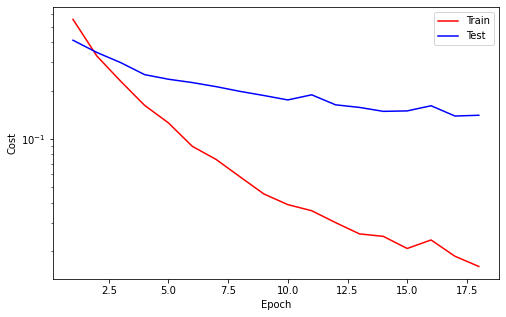

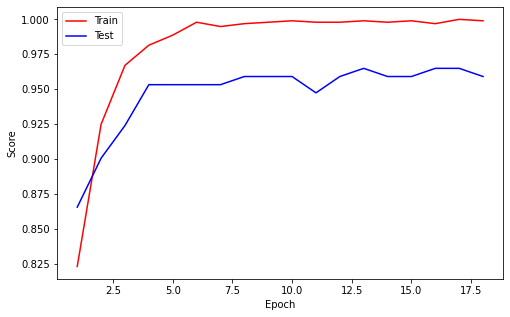

In [16]:
while True:
  train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn("test", val_set, valloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor="test_score"):
    callback.plot_cost()
    callback.plot_score()
    break

## Model 5 Benchmark

In [17]:
def predict(model, test_loader, device):
    model.eval()
    
    targets = torch.tensor([], dtype=torch.long, device=device)
    preds = torch.tensor([], device=device)
    
    with torch.no_grad():
        for data in test_loader:
            inputs = [i.to(device) for i in data[:-1]]
            labels = data[-1].to(device)
            
            outputs = model(*inputs)
            targets = torch.cat((targets, labels), 0)
            preds = torch.cat((preds, outputs), 0)
    
    targets = targets.cpu().numpy()  
    _, preds_out = torch.max(preds, 1)
    preds_out = preds_out.cpu().numpy()
    probs = nn.functional.softmax(preds, dim=1).cpu().numpy()
    
    return targets, preds_out, probs

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
target, preds, y_pred_prob = predict(model, benchmarkloader, device)

              precision    recall  f1-score   support

       daisy       0.89      0.68      0.77        50
   dandelion       0.75      0.88      0.81        50
       roses       0.95      0.78      0.86        50
  sunflowers       0.78      0.80      0.79        50
      tulips       0.77      0.94      0.85        50

    accuracy                           0.82       250
   macro avg       0.83      0.82      0.82       250
weighted avg       0.83      0.82      0.82       250



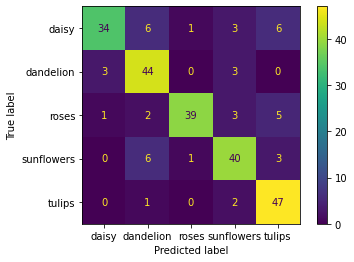

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

cf_matrix = confusion_matrix(target, preds)
print(classification_report(target, preds, target_names=label2cat))
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label2cat).plot(values_format='.4g')

# Split data to 20 and 80

In [64]:
data_domain2 = datasets.ImageFolder("flower_recognition", transform=transform)

# data_merged = torch.utils.data.ConcatDataset([data_domain1, data_domain2])

data_domain2_20_size = int(len(data_domain2) * 0.2)
data_domain2_80_size = len(data_domain2) - (data_domain2_20_size)
data_domain2_60_size = len(data_domain2) - 2*(data_domain2_20_size)

data_domain2_20_1_random, data_domain2_80_random = random_split(data_domain2, [data_domain2_20_size, data_domain2_80_size],torch.Generator().manual_seed(42))

data_domain2_20_2_random, data_domain2_60_random = random_split(data_domain2_80_random, [data_domain2_20_size, data_domain2_60_size],torch.Generator().manual_seed(42))
# trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)
# valloader = DataLoader(val_set, batch_size=bs)

In [65]:
from collections import Counter

In [66]:
labels = []
for data, label in data_domain2_20_random:
#     print(label)
    labels.append(label)
dct = dict(Counter(labels))

for k, v in dct.items():
    print(f'{label2cat[k]} has {v} instances')

dandelion has 165 instances
sunflowers has 131 instances
daisy has 95 instances
tulips has 134 instances
roses has 118 instances


In [67]:
labels = []
for data, label in data_domain2_20_1_random:
#     print(label)
    labels.append(label)
dct = dict(Counter(labels))

for k, v in dct.items():
    print(f'{label2cat[k]} has {v} instances')

dandelion has 165 instances
sunflowers has 131 instances
daisy has 95 instances
tulips has 134 instances
roses has 118 instances


In [68]:
labels = []
for data, label in data_domain2_20_2_random:
#     print(label)
    labels.append(label)
dct = dict(Counter(labels))

for k, v in dct.items():
    print(f'{label2cat[k]} has {v} instances')

daisy has 107 instances
dandelion has 154 instances
roses has 120 instances
sunflowers has 123 instances
tulips has 139 instances


# Model 6 (Random sampling v2)

In [69]:
# Merging 20% Random and Domain1
data_merged_20_random = torch.utils.data.ConcatDataset([data_domain1, data_domain2_20_1_random, data_domain2_20_2_random])

val_size = int(len(data_merged_20_random) * 0.15)
train_size = len(data_merged_20_random) - (val_size)

train_set, val_set = random_split(
    data_merged_20_random,
    [train_size, val_size]
)


trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)
valloader = DataLoader(val_set, batch_size=bs)

In [70]:
labels = []
for data, label in data_merged_20_random:
#     print(label)
    labels.append(label)
dct = dict(Counter(labels))

for k, v in dct.items():
    print(f'{label2cat[k]} has {v} instances')

daisy has 302 instances
dandelion has 419 instances
roses has 338 instances
sunflowers has 354 instances
tulips has 373 instances


In [71]:
model = ActiveLearningNet(config.output_size).to(device)
model.load_state_dict(torch.load('model3/weights_best.pth', map_location=device))

<All keys matched successfully>

In [73]:
model.unfreeze()
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback = Callback(model, config, early_stop_patience=5, outdir="model6")

Train:   0%|          | 0/24 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.1952 | Test_cost  = 0.1693 | Train_score = 0.9533 | Test_score = 0.9551 |


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.1172 | Test_cost  = 0.1557 | Train_score = 0.9803 | Test_score = 0.9625 |


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.0801 | Test_cost  = 0.1476 | Train_score = 0.9882 | Test_score = 0.9663 |


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.0521 | Test_cost  = 0.1400 | Train_score = 0.9941 | Test_score = 0.9625 |
==> EarlyStop patience =  1 | Best test_score: 0.9663


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.0350 | Test_cost  = 0.1375 | Train_score = 0.9980 | Test_score = 0.9663 |
==> EarlyStop patience =  2 | Best test_score: 0.9663


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.0260 | Test_cost  = 0.1320 | Train_score = 0.9993 | Test_score = 0.9663 |
==> EarlyStop patience =  3 | Best test_score: 0.9663


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.0204 | Test_cost  = 0.1335 | Train_score = 1.0000 | Test_score = 0.9663 |
==> EarlyStop patience =  4 | Best test_score: 0.9663


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.0173 | Test_cost  = 0.1272 | Train_score = 1.0000 | Test_score = 0.9663 |
==> EarlyStop patience =  5 | Best test_score: 0.9663
==> Execute Early Stopping at epoch: 8 | Best test_score: 0.9663
==> Best model is saved at model6


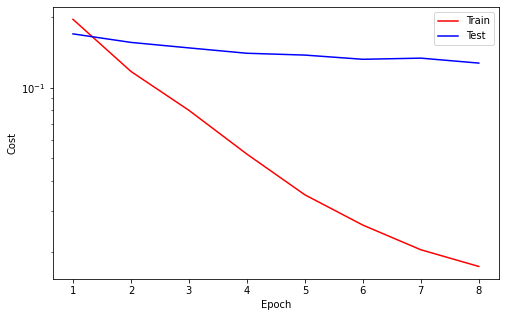

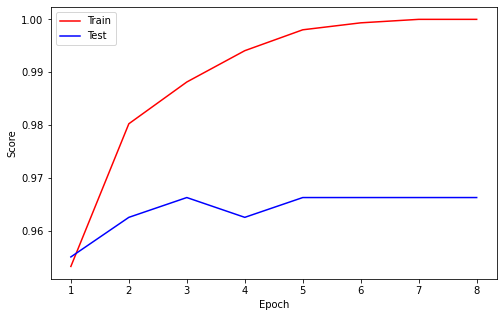

In [74]:
while True:
  train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn("test", val_set, valloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor="test_score"):
    callback.plot_cost()
    callback.plot_score()
    break

## Model 6 Benchmark

In [77]:
from sklearn.metrics import classification_report, confusion_matrix
target, preds, y_pred_prob = predict(model, benchmarkloader, device)

              precision    recall  f1-score   support

       daisy       0.98      0.82      0.89        50
   dandelion       0.91      0.96      0.93        50
       roses       0.96      0.86      0.91        50
  sunflowers       0.98      0.92      0.95        50
      tulips       0.79      1.00      0.88        50

    accuracy                           0.91       250
   macro avg       0.92      0.91      0.91       250
weighted avg       0.92      0.91      0.91       250



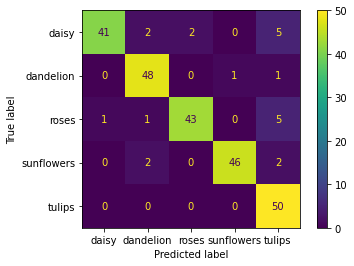

In [78]:
from sklearn.metrics import ConfusionMatrixDisplay

cf_matrix = confusion_matrix(target, preds)
print(classification_report(target, preds, target_names=label2cat))
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label2cat).plot(values_format='.4g')

# Model 7 (Least Confidence Sampling v2)

In [17]:
model = ActiveLearningNet(config.output_size).to(device)
model.load_state_dict(torch.load('model4/weights_best.pth', map_location=device))

<All keys matched successfully>

In [18]:
config = set_config({
    "output_size": len(data_domain1.classes),
    "batch_size": 32,
    "crop_size": crop_size
})

In [19]:
model.unfreeze()
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback = Callback(model, config, early_stop_patience=5, outdir="model7")

In [20]:
data_not_used = datasets.ImageFolder("data4_not_picked", transform=transform)

data_not_used_loader = DataLoader(data_not_used, batch_size=1, shuffle=True)

In [14]:
def least_confidence(prob_dist):
        """ 
        Returns the uncertainty score of an array using
        least confidence sampling in a 0-1 range where 1 is the most uncertain
        
        Assumes probability distribution is a pytorch tensor, like: 
            tensor([0.0321, 0.6439, 0.0871, 0.2369])
                    
        Keyword arguments:
            prob_dist -- a pytorch tensor of real numbers between 0 and 1 that total to 1.0
            sorted -- if the probability distribution is pre-sorted from largest to smallest
        """
        prob_dist = torch.tensor(prob_dist).to(device)
        simple_least_conf = torch.max(prob_dist) # most confident prediction
                    
        num_labels = prob_dist.numel() # number of labels
        
        normalized_least_conf = (1 - simple_least_conf) * (num_labels / (num_labels -1))
        
        return normalized_least_conf.item()

In [15]:
def get_confidence(model, data_loader, device):
    model.eval()
    
    targets = torch.tensor([], dtype=torch.long, device=device)
    preds = torch.tensor([], device=device)
    samples = torch.tensor([], device=device)
    conf = []
    
    with torch.no_grad():
        for data in data_loader:
            inputs = [i.to(device) for i in data[:-1]]
            labels = data[-1].to(device)
            outputs = model(*inputs)
            targets = torch.cat((targets, labels), 0)
            preds = torch.cat((preds, outputs), 0)
            samples = torch.cat((samples, data[0].to(device)), 0)
             
    _, preds_out = torch.max(preds, 1)
    preds_out = preds_out
    probs = nn.functional.softmax(preds, dim=1)
    for prob in probs:
        conf.append(least_confidence(prob))
    conf = torch.tensor(conf, device=device)
    return samples, conf, targets

In [16]:
def get_samples_least_conf(model, imagefolder, device, sample_pct=0.2):
    sample_size = int(len(imagefolder) * sample_pct)
    print(sample_size)
#     conf, targets= get_confidence(model, imagefolder, device)
    samples, conf, targets = get_confidence(model, imagefolder, device)
    samples_out = samples[conf.argsort()][:sample_size]
    targets_out = targets[conf.argsort()][:sample_size]
    samples_not = samples[conf.argsort()][sample_size:]
    targets_not = targets[conf.argsort()][sample_size:]
#     targets_return = torch.tensor([torch.tensor(t).to(device) for t in targets], device=device)
    return samples_out, targets_out, samples_not, targets_not

In [17]:
samples_gpu, targets_gpu, samples_not_gpu, targets_not_gpu = get_samples_least_conf(model, data_not_used_loader, device, 0.25)

643


/home/mamad/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
<ipython-input-14-e92f841e709d>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prob_dist = torch.tensor(prob_dist).to(device)


In [35]:
from torch.utils.data import TensorDataset, DataLoader

In [36]:
samples_not_cpu, targets_not_cpu = samples_not_gpu.detach().cpu(), targets_not_gpu.detach().cpu()

In [37]:
samples_cpu, targets_cpu = samples_gpu.detach().cpu(), targets_gpu.detach().cpu()

In [38]:
my_dataset = TensorDataset(samples_gpu,targets_gpu)
dataloader = DataLoader(my_dataset, batch_size=bs)

In [39]:
my_dataset2 = TensorDataset(samples_not_gpu,targets_not_gpu)
dataloader2 = DataLoader(my_dataset2, batch_size=bs)

## Saving images from sampling

In [40]:
import os
for label in label2cat:
    try:
        os.makedirs("data7_sampling/{}".format(label))
    except FileExistsError:
        # directory already exists
        pass
    
from torchvision.utils import save_image

In [41]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

for idx, data in enumerate(my_dataset):
    target = data[1]
    data = invTrans(data[0])
    save_image(data, 'data7_sampling/{}/{}'.format(label2cat[target.item()], str(idx)+'.jpg'))

In [42]:
import os
for label in label2cat:
    try:
        os.makedirs("data7_not_picked/{}".format(label))
    except FileExistsError:
        # directory already exists
        pass
    
from torchvision.utils import save_image

In [43]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

for idx, data in enumerate(my_dataset2):
    target = data[1]
    data = invTrans(data[0])
    save_image(data, 'data7_not_picked/{}/{}'.format(label2cat[target.item()], str(idx)+'.jpg'))

## Combining images from domain1 to sampling

In [44]:
!mkdir data7_merged
!rsync -avq data4_sampling/* data7_merged
!rsync -avq data7_sampling/* data7_merged
!rsync -avq oxford_102_flower/* data7_merged

## Fine-Tuning

In [21]:
data_train = datasets.ImageFolder("data7_merged", transform=transform)

val_size = int(len(data_train) * 0.15)
train_size = len(data_train) - (val_size)

train_set, val_set = random_split(
    data_train,
    [train_size, val_size]
)


trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)
valloader = DataLoader(val_set, batch_size=bs)

In [22]:
from collections import Counter

labels = []
for data, label in data_train:
#     print(label)
    labels.append(label)
dct = dict(Counter(labels))

for k, v in dct.items():
    print(f'{label2cat[k]} has {v} instances')

daisy has 312 instances
dandelion has 451 instances
roses has 212 instances
sunflowers has 328 instances
tulips has 319 instances


Train:   0%|          | 0/22 [00:00<?, ?it/s]

/home/mamad/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.1413 | Test_cost  = 0.0968 | Train_score = 0.9746 | Test_score = 0.9835 |


Train:   0%|          | 0/22 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.0707 | Test_cost  = 0.0818 | Train_score = 0.9877 | Test_score = 0.9835 |
==> EarlyStop patience =  1 | Best test_score: 0.9835


Train:   0%|          | 0/22 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.0438 | Test_cost  = 0.0748 | Train_score = 0.9942 | Test_score = 0.9835 |
==> EarlyStop patience =  2 | Best test_score: 0.9835


Train:   0%|          | 0/22 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.0304 | Test_cost  = 0.0699 | Train_score = 0.9971 | Test_score = 0.9835 |
==> EarlyStop patience =  3 | Best test_score: 0.9835


Train:   0%|          | 0/22 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.0185 | Test_cost  = 0.0685 | Train_score = 1.0000 | Test_score = 0.9835 |
==> EarlyStop patience =  4 | Best test_score: 0.9835


Train:   0%|          | 0/22 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.0135 | Test_cost  = 0.0669 | Train_score = 1.0000 | Test_score = 0.9835 |
==> EarlyStop patience =  5 | Best test_score: 0.9835
==> Execute Early Stopping at epoch: 6 | Best test_score: 0.9835
==> Best model is saved at model7


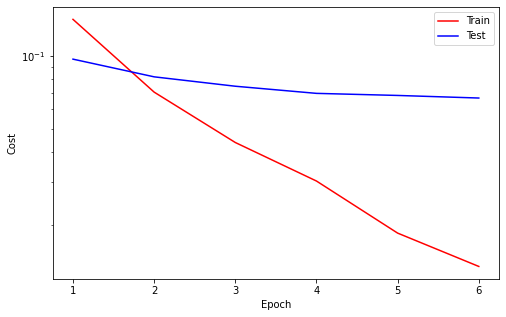

In [23]:
while True:
  train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn("test", val_set, valloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor="test_score"):
    callback.plot_cost()
    callback.plot_score()
    break

## Model 7 Benchmark

In [24]:
def predict(model, test_loader, device):
    model.eval()
    
    targets = torch.tensor([], dtype=torch.long, device=device)
    preds = torch.tensor([], device=device)
    
    with torch.no_grad():
        for data in test_loader:
            inputs = [i.to(device) for i in data[:-1]]
            labels = data[-1].to(device)
            
            outputs = model(*inputs)
            targets = torch.cat((targets, labels), 0)
            preds = torch.cat((preds, outputs), 0)
    
    targets = targets.cpu().numpy()  
    _, preds_out = torch.max(preds, 1)
    preds_out = preds_out.cpu().numpy()
    probs = nn.functional.softmax(preds, dim=1).cpu().numpy()
    
    return targets, preds_out, probs

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
target, preds, y_pred_prob = predict(model, benchmarkloader, device)

              precision    recall  f1-score   support

       daisy       0.93      0.74      0.82        50
   dandelion       0.84      0.86      0.85        50
       roses       0.95      0.70      0.80        50
  sunflowers       0.77      0.86      0.81        50
      tulips       0.74      0.98      0.84        50

    accuracy                           0.83       250
   macro avg       0.84      0.83      0.83       250
weighted avg       0.84      0.83      0.83       250



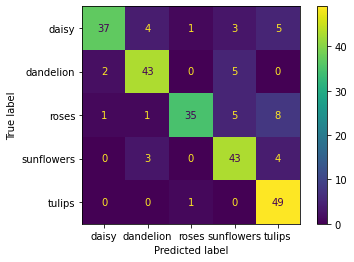

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

cf_matrix = confusion_matrix(target, preds)
print(classification_report(target, preds, target_names=label2cat))
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label2cat).plot(values_format='.4g')

# Model 8 (Margin Confidence Sampling v2)

In [13]:
model = ActiveLearningNet(config.output_size).to(device)
model.load_state_dict(torch.load('model5/weights_best.pth', map_location=device))

<All keys matched successfully>

In [14]:
config = set_config({
    "output_size": len(data_domain1.classes),
    "batch_size": 32,
    "crop_size": crop_size
})

In [15]:
model.unfreeze()
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback = Callback(model, config, early_stop_patience=5, outdir="model7")

In [19]:
data_not_used = datasets.ImageFolder("data5_not_picked", transform=transform)

data_not_used_loader = DataLoader(data_not_used, batch_size=1, shuffle=True)

In [20]:
def margin_confidence(prob_dist):
    """ 
    Returns the uncertainty score of a probability distribution using
    margin of confidence sampling in a 0-1 range where 1 is the most uncertain

    Assumes probability distribution is a pytorch tensor, like: 
        tensor([0.0321, 0.6439, 0.0871, 0.2369])

    Keyword arguments:
        prob_dist -- a pytorch tensor of real numbers between 0 and 1 that total to 1.0
        sorted -- if the probability distribution is pre-sorted from largest to smallest
    """
    difference = (prob_dist.data[0] - prob_dist.data[1]) # difference between top two props
    margin_conf = 1 - difference 

    return margin_conf.item()

In [21]:
def get_confidence(model, data_loader, device):
    model.eval()
    
    targets = torch.tensor([], dtype=torch.long, device=device)
    preds = torch.tensor([], device=device)
    samples = torch.tensor([], device=device)
    conf = []
    
    with torch.no_grad():
        for data in data_loader:
            inputs = [i.to(device) for i in data[:-1]]
            labels = data[-1].to(device)
            outputs = model(*inputs)
            targets = torch.cat((targets, labels), 0)
            preds = torch.cat((preds, outputs), 0)
            samples = torch.cat((samples, data[0].to(device)), 0)
             
    _, preds_out = torch.max(preds, 1)
    preds_out = preds_out
    probs = nn.functional.softmax(preds, dim=1)
    for prob in probs:
        conf.append(margin_confidence(prob))
    conf = torch.tensor(conf, device=device)
    return samples, conf, targets

In [22]:
def get_samples_least_conf(model, imagefolder, device, sample_pct=0.2):
    sample_size = int(len(imagefolder) * sample_pct)
    print(sample_size)
#     conf, targets= get_confidence(model, imagefolder, device)
    samples, conf, targets = get_confidence(model, imagefolder, device)
    samples_out = samples[conf.argsort()][:sample_size]
    targets_out = targets[conf.argsort()][:sample_size]
    samples_not = samples[conf.argsort()][sample_size:]
    targets_not = targets[conf.argsort()][sample_size:]
#     targets_return = torch.tensor([torch.tensor(t).to(device) for t in targets], device=device)
    return samples_out, targets_out, samples_not, targets_not

In [23]:
samples_gpu, targets_gpu, samples_not_gpu, targets_not_gpu = get_samples_least_conf(model, data_not_used_loader, device, 0.25)

643


/home/mamad/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [24]:
from torch.utils.data import TensorDataset, DataLoader

In [25]:
samples_not_cpu, targets_not_cpu = samples_not_gpu.detach().cpu(), targets_not_gpu.detach().cpu()

In [26]:
samples_cpu, targets_cpu = samples_gpu.detach().cpu(), targets_gpu.detach().cpu()

In [27]:
my_dataset = TensorDataset(samples_gpu,targets_gpu)
dataloader = DataLoader(my_dataset, batch_size=bs)

In [28]:
my_dataset2 = TensorDataset(samples_not_gpu,targets_not_gpu)
dataloader2 = DataLoader(my_dataset2, batch_size=bs)

## Saving images from sampling

In [29]:
import os
for label in label2cat:
    try:
        os.makedirs("data8_sampling/{}".format(label))
    except FileExistsError:
        # directory already exists
        pass
    
from torchvision.utils import save_image

In [30]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

for idx, data in enumerate(my_dataset):
    target = data[1]
    data = invTrans(data[0])
    save_image(data, 'data8_sampling/{}/{}'.format(label2cat[target.item()], str(idx)+'.jpg'))

In [31]:
import os
for label in label2cat:
    try:
        os.makedirs("data8_not_picked/{}".format(label))
    except FileExistsError:
        # directory already exists
        pass
    
from torchvision.utils import save_image

In [32]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

for idx, data in enumerate(my_dataset2):
    target = data[1]
    data = invTrans(data[0])
    save_image(data, 'data8_not_picked/{}/{}'.format(label2cat[target.item()], str(idx)+'.jpg'))

## Combining images from domain1 to sampling

In [33]:
!mkdir data8_merged
!rsync -avq data5_sampling/* data8_merged
!rsync -avq data8_sampling/* data8_merged
!rsync -avq oxford_102_flower/* data8_merged

## Fine-Tuning

In [16]:
data_train = datasets.ImageFolder("data8_merged", transform=transform)

val_size = int(len(data_train) * 0.15)
train_size = len(data_train) - (val_size)

train_set, val_set = random_split(
    data_train,
    [train_size, val_size]
)


trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)
valloader = DataLoader(val_set, batch_size=bs)

In [17]:
from collections import Counter

labels = []
for data, label in data_train:
#     print(label)
    labels.append(label)
dct = dict(Counter(labels))

for k, v in dct.items():
    print(f'{label2cat[k]} has {v} instances')

daisy has 527 instances
dandelion has 132 instances
roses has 391 instances
sunflowers has 236 instances
tulips has 386 instances


In [18]:
while True:
  train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn("test", val_set, valloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor="test_score"):
    callback.plot_cost()
    callback.plot_score()
    break

Train:   0%|          | 0/23 [00:00<?, ?it/s]

/home/mamad/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.1749 | Test_cost  = 0.1292 | Train_score = 0.9395 | Test_score = 0.9560 |


Train:   0%|          | 0/23 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.0827 | Test_cost  = 0.1244 | Train_score = 0.9775 | Test_score = 0.9640 |


Train:   0%|          | 0/23 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.0606 | Test_cost  = 0.1269 | Train_score = 0.9895 | Test_score = 0.9680 |


Train:   0%|          | 0/23 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.0399 | Test_cost  = 0.1250 | Train_score = 0.9972 | Test_score = 0.9640 |
==> EarlyStop patience =  1 | Best test_score: 0.9680


Train:   0%|          | 0/23 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.0277 | Test_cost  = 0.1219 | Train_score = 0.9979 | Test_score = 0.9680 |
==> EarlyStop patience =  2 | Best test_score: 0.9680


Train:   0%|          | 0/23 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.0266 | Test_cost  = 0.1201 | Train_score = 0.9979 | Test_score = 0.9720 |


Train:   0%|          | 0/23 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.0209 | Test_cost  = 0.1213 | Train_score = 0.9993 | Test_score = 0.9680 |
==> EarlyStop patience =  1 | Best test_score: 0.9720


Train:   0%|          | 0/23 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.0150 | Test_cost  = 0.1251 | Train_score = 1.0000 | Test_score = 0.9680 |
==> EarlyStop patience =  2 | Best test_score: 0.9720


Train:   0%|          | 0/23 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.0121 | Test_cost  = 0.1216 | Train_score = 1.0000 | Test_score = 0.9640 |
==> EarlyStop patience =  3 | Best test_score: 0.9720


Train:   0%|          | 0/23 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.0095 | Test_cost  = 0.1220 | Train_score = 1.0000 | Test_score = 0.9640 |
==> EarlyStop patience =  4 | Best test_score: 0.9720


Train:   0%|          | 0/23 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.0124 | Test_cost  = 0.1213 | Train_score = 0.9979 | Test_score = 0.9640 |
==> EarlyStop patience =  5 | Best test_score: 0.9720
==> Execute Early Stopping at epoch: 11 | Best test_score: 0.9720
==> Best model is saved at model7


## Model 8 Benchmark

In [20]:
def predict(model, test_loader, device):
    model.eval()
    
    targets = torch.tensor([], dtype=torch.long, device=device)
    preds = torch.tensor([], device=device)
    
    with torch.no_grad():
        for data in test_loader:
            inputs = [i.to(device) for i in data[:-1]]
            labels = data[-1].to(device)
            
            outputs = model(*inputs)
            targets = torch.cat((targets, labels), 0)
            preds = torch.cat((preds, outputs), 0)
    
    targets = targets.cpu().numpy()  
    _, preds_out = torch.max(preds, 1)
    preds_out = preds_out.cpu().numpy()
    probs = nn.functional.softmax(preds, dim=1).cpu().numpy()
    
    return targets, preds_out, probs

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
target, preds, y_pred_prob = predict(model, benchmarkloader, device)

              precision    recall  f1-score   support

       daisy       0.93      0.80      0.86        50
   dandelion       0.79      0.90      0.84        50
       roses       0.93      0.80      0.86        50
  sunflowers       0.93      0.82      0.87        50
      tulips       0.78      0.98      0.87        50

    accuracy                           0.86       250
   macro avg       0.87      0.86      0.86       250
weighted avg       0.87      0.86      0.86       250



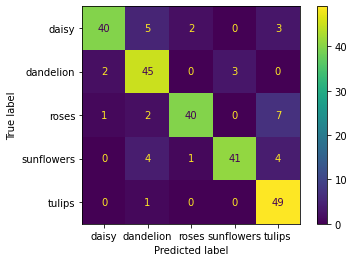

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

cf_matrix = confusion_matrix(target, preds)
print(classification_report(target, preds, target_names=label2cat))
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label2cat).plot(values_format='.4g')